<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/44-carDetector-cnn/44_carDetector_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import wandb
from wandb.keras import WandbCallback
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [4]:
wandb.init(project ="car_Detector")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
config = wandb.config
config.learning_rate = 0.001


In [6]:
# def my_preprocess(image):
#   image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#   return image

**Dataset**

In [7]:
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [8]:
dataset_path = "/content/drive/MyDrive/datasets/cars"
width = height = 224

idg = ImageDataGenerator(
    rescale = 1./255,
    # Augmentation
    horizontal_flip = True,
    zoom_range=0.1,
    rotation_range = 15,
    brightness_range = (0.8, 1.2),
    # preprocessing_function = my_preprocess
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    subset= "training",
    
)

val_data = idg.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    class_mode= "categorical",
    subset= "validation"
)

Found 634 images belonging to 4 classes.
Found 157 images belonging to 4 classes.


In [9]:
model = tf.keras.models.Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=( width, height, 3)),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPool2D(),
        Conv2D(32, (3, 3), activation="relu"),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPool2D(),
        Conv2D(64, (3, 3), activation="relu"),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPool2D(),

        Flatten(),
        # Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(4, activation="softmax"),


])

In [10]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= config.learning_rate),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy']
              )

In [11]:
model_history = model.fit(train_data, epochs= 25, validation_data= val_data, callbacks=[WandbCallback()])

Epoch 1/25
20/20 [==============================] - 484s 25s/step - loss: 1.3811 - accuracy: 0.2981 - val_loss: 1.2719 - val_accuracy: 0.3694 - _timestamp: 1648745621.0000 - _runtime: 580.0000
Epoch 2/25
20/20 [==============================] - 29s 1s/step - loss: 1.2108 - accuracy: 0.4085 - val_loss: 1.0993 - val_accuracy: 0.4841 - _timestamp: 1648745669.0000 - _runtime: 628.0000
Epoch 3/25
20/20 [==============================] - 29s 1s/step - loss: 1.1538 - accuracy: 0.4700 - val_loss: 1.3257 - val_accuracy: 0.3822 - _timestamp: 1648745698.0000 - _runtime: 657.0000
Epoch 4/25
20/20 [==============================] - 29s 1s/step - loss: 1.0625 - accuracy: 0.5331 - val_loss: 1.0676 - val_accuracy: 0.5159 - _timestamp: 1648745727.0000 - _runtime: 686.0000
Epoch 5/25
20/20 [==============================] - 29s 1s/step - loss: 0.9588 - accuracy: 0.5804 - val_loss: 1.1245 - val_accuracy: 0.5032 - _timestamp: 1648745756.0000 - _runtime: 715.0000
Epoch 6/25
20/20 [=========================

In [23]:
model.fit(train_data, epochs= 1, validation_data= val_data, callbacks=[WandbCallback()])

20/20 [==============================] - 30s 1s/step - loss: 0.2476 - accuracy: 0.8959 - val_loss: 1.6409 - val_accuracy: 0.6497 - _timestamp: 1648746848.0000 - _runtime: 1807.0000


**Test**

In [25]:
dataset_path = "/content/drive/MyDrive/datasets/Tests/cars"

idg = ImageDataGenerator(
    rescale = 1./ 255,
)

test_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
)
test_loss, test_acc= model.evaluate(test_data)


Found 16 images belonging to 4 classes.
1/1 [==============================] - 0s 437ms/step - loss: 1.0413 - accuracy: 0.7500


In [26]:
model.save("/content/drive/MyDrive/models/44-carDetector-cnn.h5")

In [27]:
print(test_loss)
print(test_acc)

1.0413060188293457
0.75


[[4 0 0 0]
 [0 2 1 1]
 [0 0 3 1]
 [0 1 0 3]]


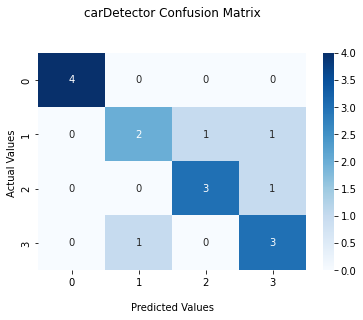

In [29]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))


cv_confMTX = confusion_matrix(test_data.classes, Y_pred)
print(cv_confMTX)

ax = sns.heatmap(cv_confMTX, annot=True, cmap='Blues')
ax.set_title('carDetector Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

**Inference**

In [32]:
image = cv2.imread("/content/drive/MyDrive/datasets/Inference/cars/image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (width, height))
image = image / 255
image = image.reshape(1, width, height, 3)  # 3d -> 4D

result = model.predict(image)
print(result)
pred = np.argmax(result)
print(pred)
if pred == 0:
  print("Bulldozer 🚜")
  #  print("\U0001F699")
elif pred==1:
  print("Bus 🚌")
  # print("\U0001F69A")
elif pred==2:
  # print("")
  print("pickup \U0001F6FB")
elif pred==3:
  print("sedan 🚗")
  # print("\U0001F697")  


[[1.1073972e-06 1.8992060e-03 5.9329677e-02 9.3876994e-01]]
3
sedan 🚗
